# REGRESIÓN LOGÍSTICA (RL) - BASELINE 

Objetivo: Establecer un modelo baseline usando Regresión Logística para comparar con Random Forest y Gradient Boosting

Fases temporales:
- T0 (Matrícula)        : Variables disponibles al momento de inscripción
- T1 (Fin 1er Semestre) : T0 + variables académicas del 1er semestre, información de matrícula y deudor
- T2 (Fin 2do Semestre) : T1 + variables académicas del 2do semestre

Preprocesamiento específico para Regrsión Lineal:
- Escalado
- Label Encoding para categóricas
- Target Encoding para 'course'

Pipeline:
1. Carga de datos preprocesados
2. Definición de variables por fase temporal
3. Split estratificado (80/20)
4. Preprocesamiento específico para RL 
5. Entrenamiento con Cross-Validation 5-fold
6. Evaluación de resultados Cross-Validation 5-fold
7. Comparación de resultados por fase

## 0. Librerias y configuración

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Preprocesamiento
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Modelo
from sklearn.linear_model import LogisticRegression

# Métricas
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, average_precision_score
)

# Target Encoding
from category_encoders import TargetEncoder

# MLFLOW
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Seed para reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Directorio de salida
OUTPUT_DIR = "../outputs/figures/modelado/baseline_RL/"
OUTPUT_DIR_REPORTES = "../outputs/models/baseline_RL/"
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR_REPORTES, exist_ok=True)

# CONFIGURACIÓN MLFLOW
# Nombre del experimento
EXPERIMENT_NAME = "TFM_Dropout_Prediction"

# Tracking URI (por defecto usa carpeta mlruns en el directorio actual)
# Opciones:
#   - "mlruns" (local, carpeta por defecto)
#   - "sqlite:///mlflow.db" (SQLite local)
#   - "http://localhost:5000" (servidor MLflow remoto)
MLFLOW_TRACKING_URI = "../mlruns"

# Configurar MLflow
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)

# Obtener información del experimento
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)

print("======================================================================")
print("  CONFIGURACIÓN MLFLOW")
print("======================================================================")
print(f"\nTracking URI: {MLFLOW_TRACKING_URI}")
print(f"Experiment Name: {EXPERIMENT_NAME}")
print(f"Experiment ID: {experiment.experiment_id if experiment else 'Nuevo'}")
print(f"\nPara ver los resultados ejecuta en terminal:")
print(f"   mlflow ui --port 5000")
print(f"   Luego abre: http://localhost:5000")


  CONFIGURACIÓN MLFLOW

Tracking URI: ../mlruns
Experiment Name: TFM_Dropout_Prediction
Experiment ID: 570026133514462797

Para ver los resultados ejecuta en terminal:
   mlflow ui --port 5000
   Luego abre: http://localhost:5000


## 1. Carga de datos preprocesados

In [20]:
# Cargar dataset preprocesado
df_preproc = pd.read_csv('../data/processed/preprocessed_data.csv')
df = df_preproc.copy()  

print(f"Dataset cargado: {df.shape[0]} filas x {df.shape[1]} columnas")
print(f"\nTarget binario:")
print(df['target_binario'].value_counts())
print(f"\nRatio target binario: {df['target_binario'].value_counts()[0] / df['target_binario'].value_counts()[1]:.2f}:1")

df.head()

Dataset cargado: 4424 filas x 36 columnas

Target binario:
target_binario
0    3003
1    1421
Name: count, dtype: int64

Ratio target binario: 2.11:1


,application_order,course,daytimeevening_attendance,previous_qualification_grade,admission_grade,displaced,educational_special_needs,debtor,tuition_fees_up_to_date,gender,scholarship_holder,age_at_enrollment,international,curricular_units_1st_sem_credited,curricular_units_1st_sem_enrolled,curricular_units_1st_sem_evaluations,curricular_units_1st_sem_approved,curricular_units_1st_sem_grade,curricular_units_1st_sem_without_evaluations,curricular_units_2nd_sem_credited,curricular_units_2nd_sem_enrolled,curricular_units_2nd_sem_evaluations,curricular_units_2nd_sem_approved,curricular_units_2nd_sem_grade,curricular_units_2nd_sem_without_evaluations,unemployment_rate,inflation_rate,gdp,is_single,application_mode_risk,previous_qualification_risk,mothers_qualification_level,fathers_qualification_level,mothers_occupation_level,fathers_occupation_level,target_binario
0,5,171,1,122.0000,127.3000,1,0,0,1,1,0,20,0,0,0,0,0,0.0000,0,0,0,0,0,0.0000,0,10.8000,1.4000,1.7400,1,Bajo_Riesgo,Bajo_Riesgo,Basica_Media,Secundaria,Otro_Trabajo,Otro_Trabajo,1
1,1,9254,1,160.0000,142.5000,1,0,0,0,1,0,19,0,0,6,6,6,14.0000,0,0,6,6,6,13.6667,0,13.9000,-0.3000,0.7900,1,Bajo_Riesgo,Bajo_Riesgo,Secundaria,Superior,Profesional,Profesional,0
2,5,9070,1,122.0000,124.8000,1,0,0,0,1,0,19,0,0,6,0,0,0.0000,0,0,6,0,0,0.0000,0,10.8000,1.4000,1.7400,1,Bajo_Riesgo,Bajo_Riesgo,Basica_Baja,Basica_Baja,Otro_Trabajo,Otro_Trabajo,1
3,2,9773,1,122.0000,119.6000,1,0,0,1,0,0,20,0,0,6,8,6,13.4286,0,0,6,10,5,12.4000,0,9.4000,-0.8000,-3.1200,1,Bajo_Riesgo,Bajo_Riesgo,Basica_Media,Basica_Baja,Otro_Trabajo,Profesional,0
4,1,8014,0,100.0000,141.5000,0,0,0,1,0,0,45,0,0,6,9,5,12.3333,0,0,6,6,6,13.0000,0,13.9000,-0.3000,0.7900,0,Alto_Riesgo,Bajo_Riesgo,Basica_Baja,Basica_Media,Otro_Trabajo,Otro_Trabajo,0


## 2. Definición de variables por fase temporal (T0, T1, T2)

In [21]:
# TARGET
TARGET = 'target_binario'


# VARIABLES BINARIAS
VARS_BINARIAS_T0 = [
    'daytimeevening_attendance',
    'displaced',
    'educational_special_needs',
    'gender',
    'scholarship_holder',
    'international',
    'is_single'
]

VARS_BINARIAS_T1 = [
    'debtor',
    'tuition_fees_up_to_date'
]

# VARIABLES NUMÉRICAS (requiere escalado)
VARS_NUMERICAS_T0 = [
    'age_at_enrollment',
    'admission_grade',
    'previous_qualification_grade'
]

VARS_NUMERICAS_T1 = [
    'curricular_units_1st_sem_credited',
    'curricular_units_1st_sem_enrolled',
    'curricular_units_1st_sem_evaluations',
    'curricular_units_1st_sem_approved',
    'curricular_units_1st_sem_grade',
    'curricular_units_1st_sem_without_evaluations',
    'unemployment_rate',
    'inflation_rate',
    'gdp'
]

VARS_NUMERICAS_T2 = [
    'curricular_units_2nd_sem_credited',
    'curricular_units_2nd_sem_enrolled',
    'curricular_units_2nd_sem_evaluations',
    'curricular_units_2nd_sem_approved',
    'curricular_units_2nd_sem_grade',
    'curricular_units_2nd_sem_without_evaluations'
]

# VARIABLES CATEGÓRICAS AGRUPADAS (requiere One-Hot Encoding)
VARS_CATEGORICAS_AGRUPADAS_T0 = [
    'application_mode_risk',
    'previous_qualification_risk',
    'mothers_qualification_level',
    'fathers_qualification_level',
    'mothers_occupation_level',
    'fathers_occupation_level'
]

# VARIABLES CATEGÓRICAS PARA TARGET ENCODING
VARS_TARGET_ENCODING_T0 = ['course']


# VARIABLE ORDINAL (se trata como numérica)
VARS_ORDINALES_T0 = ['application_order']


# DEFINICIÓN DE VARIABLES POR FASE TEMPORAL
# T0: Variables disponibles al momento de matrícula
VARS_T0 = (
    VARS_BINARIAS_T0 +
    VARS_NUMERICAS_T0 +
    VARS_CATEGORICAS_AGRUPADAS_T0 +
    VARS_TARGET_ENCODING_T0 +
    VARS_ORDINALES_T0
)

# T1: T0 + variables del 1er semestre +  variables debtor y tuition_fees_up_to_date
VARS_T1 = (
    VARS_T0 +
    VARS_BINARIAS_T1 +
    VARS_NUMERICAS_T1
)

# T2: T1 + variables del 2do semestre
VARS_T2 = (
    VARS_T1 +
    VARS_NUMERICAS_T2
)

print("================================================================================")
print("  VARIABLES POR FASE TEMPORAL")
print("================================================================================")
print(f"\n T0 (Matrícula): {len(VARS_T0)} variables")
print(f" T1 (Fin 1er Sem): {len(VARS_T1)} variables (+{len(VARS_T1) - len(VARS_T0)})")
print(f" T2 (Fin 2do Sem): {len(VARS_T2)} variables (+{len(VARS_T2) - len(VARS_T1)})")

  VARIABLES POR FASE TEMPORAL

 T0 (Matrícula): 18 variables
 T1 (Fin 1er Sem): 29 variables (+11)
 T2 (Fin 2do Sem): 35 variables (+6)


## 3. Split TRAIN/TEST 

In [22]:
# Split se hace en totalidad del dataste, posteriormente se seleccionan las variables según la fase temporal para entrenemiento y evaluación
X = df[VARS_T2].copy()
y = df[TARGET].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

print("================================================================================")
print("  SPLIT TRAIN/TEST")
print("================================================================================")
print(f"\nCantidad de registros Entrenamiento: {X_train.shape[0]} ({X_train.shape[0]/len(df)*100:.1f}%)")
print(f"Cantidad de registros Test:  {X_test.shape[0]} ({X_test.shape[0]/len(df)*100:.1f}%)")

print(f"\nDistribución del target en Entrenamiento:")
print(y_train.value_counts())
print(f"Ratio: {y_train.value_counts()[0] / y_train.value_counts()[1]:.2f}:1")

print(f"\nDistribución del target en Test:")
print(y_test.value_counts())
print(f"Ratio: {y_test.value_counts()[0] / y_test.value_counts()[1]:.2f}:1")

  SPLIT TRAIN/TEST

Cantidad de registros Entrenamiento: 3539 (80.0%)
Cantidad de registros Test:  885 (20.0%)

Distribución del target en Entrenamiento:
target_binario
0    2402
1    1137
Name: count, dtype: int64
Ratio: 2.11:1

Distribución del target en Test:
target_binario
0    601
1    284
Name: count, dtype: int64
Ratio: 2.12:1


## 4. Funciones de preprocesamiento para RL

In [23]:
def obtiene_variables_por_fase(fase):
    # Retorna las listas de variables según la fase temporal, retorna diccionario con variables de la fase

    if fase == 'T0':
        return {
            'binarias': VARS_BINARIAS_T0,
            'numericas': VARS_NUMERICAS_T0 + VARS_ORDINALES_T0,
            'categoricas_ohe': VARS_CATEGORICAS_AGRUPADAS_T0,
            'categoricas_te': VARS_TARGET_ENCODING_T0,
            'todas': VARS_T0
        }
    elif fase == 'T1':
        return {
            'binarias': VARS_BINARIAS_T0 + VARS_BINARIAS_T1,
            'numericas': VARS_NUMERICAS_T0 + VARS_ORDINALES_T0 + VARS_NUMERICAS_T1,
            'categoricas_ohe': VARS_CATEGORICAS_AGRUPADAS_T0,
            'categoricas_te': VARS_TARGET_ENCODING_T0,
            'todas': VARS_T1
        }
    elif fase == 'T2':
        return {
            'binarias': VARS_BINARIAS_T0 + VARS_BINARIAS_T1,
            'numericas': VARS_NUMERICAS_T0 + VARS_ORDINALES_T0 + VARS_NUMERICAS_T1 + VARS_NUMERICAS_T2,
            'categoricas_ohe': VARS_CATEGORICAS_AGRUPADAS_T0,
            'categoricas_te': VARS_TARGET_ENCODING_T0,
            'todas': VARS_T2
        }
    else:
        raise ValueError(f"Fase no válida: {fase}. Usar 'T0', 'T1', o 'T2'")


def preprocesamiento_RL_con_transformaciones(X_train, X_test, y_train, fase):
    """    
    Preprocesa los datos para regresión Logística:
    - StandardScaler para numéricas
    - One-Hot Encoding para categóricas agrupadas
    - Target Encoding para 'course'
    
    Retorna:
    X_train_processed, X_test_processed, feature_names, preprocessors
    """
        
    variables_fase = obtiene_variables_por_fase(fase)

    variables_fase.values
    
    # Selecciona las variables de la fase
    X_train_fase = X_train[variables_fase['todas']].copy()
    X_test_fase = X_test[variables_fase['todas']].copy()


    # =========================================================================
    # VARIABLES ZERO-INFLATED
    # =========================================================================
    vars_zero_inflated = [
        'curricular_units_1st_sem_credited',
        'curricular_units_2nd_sem_credited',
        'curricular_units_1st_sem_without_evaluations',
        'curricular_units_2nd_sem_without_evaluations'
    ]
    
    # Filtra las variables que existen en la fase
    vars_zero_inflated_fase = [v for v in vars_zero_inflated if v in X_train_fase.columns]
    
    # Aplica log a variables para variables zero-inflated y variable de edad
    for col in vars_zero_inflated_fase:
        X_train_fase[col] = np.log1p(X_train_fase[col])
        X_test_fase[col] = np.log1p(X_test_fase[col])
        
    #  Aplica log a variables para variable age
    X_train_fase['age_at_enrollment'] = np.log1p(X_train_fase['age_at_enrollment'])
    X_test_fase['age_at_enrollment'] = np.log1p(X_test_fase['age_at_enrollment'])
        
        
    # TARGET ENCODING para 'course'
    te = TargetEncoder(cols=variables_fase['categoricas_te'], smoothing=0.3)
    
    for col in variables_fase['categoricas_te']:
        X_train_fase[col + '_encoded'] = te.fit_transform(X_train_fase[[col]], y_train)[col]
        X_test_fase[col + '_encoded'] = te.transform(X_test_fase[[col]])[col]
        # Eliminar columna original
        X_train_fase = X_train_fase.drop(columns=[col])
        X_test_fase = X_test_fase.drop(columns=[col])
    
    # Actualiza lista de numéricas y agrega las encoded)
    vars_numericas_updated = variables_fase['numericas'] + [col + '_encoded' for col in variables_fase['categoricas_te']]
    
    # ONE-HOT ENCODING para categóricas agrupadas
    X_train_fase = pd.get_dummies(
        X_train_fase, 
        columns=variables_fase['categoricas_ohe'], 
        drop_first=True,
        dtype=int
    )
    X_test_fase = pd.get_dummies(
        X_test_fase, 
        columns=variables_fase['categoricas_ohe'], 
        drop_first=True,
        dtype=int
    )
    
    # Alinea columnas (para categorías en test que no están en train)
    X_train_fase, X_test_fase = X_train_fase.align(X_test_fase, join='left', axis=1, fill_value=0)
    
    # STANDARD SCALER para numéricas
    scaler = StandardScaler()
    
    # Identifica columnas numéricas en el dataframe procesado
    cols_to_scale = [c for c in vars_numericas_updated if c in X_train_fase.columns]
    
    X_train_fase[cols_to_scale] = scaler.fit_transform(X_train_fase[cols_to_scale])
    X_test_fase[cols_to_scale] = scaler.transform(X_test_fase[cols_to_scale])
    
    # Guarda información
    feature_names = X_train_fase.columns.tolist()
    preprocessors = {
        'target_encoder': te,
        'scaler': scaler,
        'feature_names': feature_names
    }
    
    return X_train_fase, X_test_fase, feature_names, preprocessors


## 5. Función de entrenamiento

In [24]:
# Entrenamiento con parámetros por defecto
def entrena_RL(X_train, y_train, fase, cv_folds=5):

    mlflow.end_run()
    print("================================================================================")
    print(f"  ENTRENAMIENTO REGRESIÓN LOGÍSTICA - FASE {fase}")
    print("================================================================================")
    print(f"\nVariables: {X_train.shape[1]}")
    print(f" Cantidad de registros en dataset de entrenamiento: {X_train.shape[0]}")
    
    # Cross-Validation 
    print(f"\n Cross-Validation ({cv_folds}-fold):")
    
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_STATE)
    
    # Almacena resultados por fold
    cv_results = {
        'train_accuracy': [], 'test_accuracy': [],
        'train_precision': [], 'test_precision': [],
        'train_recall': [], 'test_recall': [],
        'train_f1': [], 'test_f1': [],
        'train_roc_auc': [], 'test_roc_auc': []
    }

    for train_idx, val_idx in cv.split(X_train, y_train):
        X_fold_train = X_train.iloc[train_idx]
        X_fold_val = X_train.iloc[val_idx]
        y_fold_train = y_train.iloc[train_idx]
        y_fold_val = y_train.iloc[val_idx]
        
        # Crear y entrenar modelo
        modelo_RL = LogisticRegression(
            penalty='l2',
            C=1.0,
            solver='lbfgs',
            class_weight='balanced',
            max_iter=100,
            random_state=RANDOM_STATE
        )
        modelo_RL.fit(X_fold_train, y_fold_train)
        
        # Predicciones
        y_train_pred = modelo_RL.predict(X_fold_train)
        y_train_proba = modelo_RL.predict_proba(X_fold_train)[:, 1]
        y_val_pred = modelo_RL.predict(X_fold_val)
        y_val_proba = modelo_RL.predict_proba(X_fold_val)[:, 1]
        
        # Métricas Train
        cv_results['train_accuracy'].append(accuracy_score(y_fold_train, y_train_pred))
        cv_results['train_precision'].append(precision_score(y_fold_train, y_train_pred))
        cv_results['train_recall'].append(recall_score(y_fold_train, y_train_pred))
        cv_results['train_f1'].append(f1_score(y_fold_train, y_train_pred))
        cv_results['train_roc_auc'].append(roc_auc_score(y_fold_train, y_train_proba))
        
        # Métricas Validation
        cv_results['test_accuracy'].append(accuracy_score(y_fold_val, y_val_pred))
        cv_results['test_precision'].append(precision_score(y_fold_val, y_val_pred))
        cv_results['test_recall'].append(recall_score(y_fold_val, y_val_pred))
        cv_results['test_f1'].append(f1_score(y_fold_val, y_val_pred))
        cv_results['test_roc_auc'].append(roc_auc_score(y_fold_val, y_val_proba))
   
    # Resultados por fold
    print("\n Resultados por fold:")
    for i in range(cv_folds):
        print(f"\n  Fold {i+1}:")
        for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
            train_score = cv_results[f'train_{metric}'][i]
            val_score = cv_results[f'test_{metric}'][i]
            print(f"    {metric:<10} | Train: {train_score:.4f} | Val: {val_score:.4f}")

    # =========================================================================
    # CURVA DE REGULARIZACIÓN: F1-Score vs C
    # =========================================================================
    print(f"\Genera curva de regularización (F1 vs C)...")
    
    # Rango de C a evaluar (escala logarítmica)
    C_range = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
    
    cv_curve = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_STATE)
    
    all_train_f1 = []
    all_val_f1 = []
    
    for fold, (train_idx, val_idx) in enumerate(cv_curve.split(X_train, y_train)):
        X_fold_train = X_train.iloc[train_idx]
        X_fold_val = X_train.iloc[val_idx]
        y_fold_train = y_train.iloc[train_idx]
        y_fold_val = y_train.iloc[val_idx]
        
        train_f1_fold = []
        val_f1_fold = []
        
        for C in C_range:
            modelo_temp = LogisticRegression(
                penalty='l2',
                C=C,
                solver='lbfgs',
                class_weight='balanced',
                max_iter=1000,
                random_state=RANDOM_STATE
            )
            modelo_temp.fit(X_fold_train, y_fold_train)
            
            y_train_pred = modelo_temp.predict(X_fold_train)
            y_val_pred = modelo_temp.predict(X_fold_val)
            
            train_f1_fold.append(f1_score(y_fold_train, y_train_pred))
            val_f1_fold.append(f1_score(y_fold_val, y_val_pred))
        
        all_train_f1.append(train_f1_fold)
        all_val_f1.append(val_f1_fold)
    
    # Calcular media y std
    train_f1_mean = np.array(all_train_f1).mean(axis=0)
    train_f1_std = np.array(all_train_f1).std(axis=0)
    val_f1_mean = np.array(all_val_f1).mean(axis=0)
    val_f1_std = np.array(all_val_f1).std(axis=0)
    
    # =========================================================================
    # GRAFICAR CURVA DE REGULARIZACIÓN
    # =========================================================================
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Train
    ax.plot(C_range, train_f1_mean, label='Train F1', color='#3498DB', linewidth=2, marker='o')
    ax.fill_between(C_range, 
                    train_f1_mean - train_f1_std, 
                    train_f1_mean + train_f1_std, 
                    color='#3498DB', alpha=0.2)
    
    # Validation
    ax.plot(C_range, val_f1_mean, label='Validation F1', color='#E74C3C', linewidth=2, marker='s')
    ax.fill_between(C_range, 
                    val_f1_mean - val_f1_std, 
                    val_f1_mean + val_f1_std, 
                    color='#E74C3C', alpha=0.2)
    
    ax.set_xscale('log')
    ax.set_xlabel('C (Regularización Inversa: menor C = más regularización)', fontsize=12)
    ax.set_ylabel('F1-Score', fontsize=12)
    ax.set_title(f'Curva de Regularización - Regresión Logística {fase}\n(Media ± Std de {cv_folds}-Fold CV) - Sin Optimizar', fontsize=14)
    ax.legend(loc='lower right', fontsize=11)
    ax.grid(True, alpha=0.3)
    
    # Marcar C por defecto (1.0)
    ax.axvline(x=1.0, color='green', linestyle='--', alpha=0.7, linewidth=2)
    idx_default = C_range.index(1.0)
    ax.scatter([1.0], [val_f1_mean[idx_default]], color='green', s=150, zorder=5, 
               label=f'C default: 1.0')
    
    # Marcar mejor C
    best_idx = np.argmax(val_f1_mean)
    best_C = C_range[best_idx]
    if best_C != 1.0:
        ax.axvline(x=best_C, color='orange', linestyle=':', alpha=0.7, linewidth=2)
        ax.scatter([best_C], [val_f1_mean[best_idx]], color='orange', s=150, zorder=5,
                   label=f'Mejor C: {best_C}')
    
    ax.legend(loc='lower right', fontsize=10)
    
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}curva_regularizacion_rl_{fase}.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Calcula gap en C=1.0 (default)
    gap_default = train_f1_mean[idx_default] - val_f1_mean[idx_default]
    gap_best = train_f1_mean[best_idx] - val_f1_mean[best_idx]
    
    print(f"\nResumen Curva de Regularización:")
    print(f"   C por defecto: 1.0")
    print(f"   Mejor C (curva): {best_C}")
    print(f"   Train F1 en C=1.0: {train_f1_mean[idx_default]:.4f}")
    print(f"   Val F1 en C=1.0: {val_f1_mean[idx_default]:.4f}")
    print(f"   Gap en C=1.0: {gap_default:.4f}")
    print(f"   Val F1 en mejor C: {val_f1_mean[best_idx]:.4f}")
    print(f"   Gap en mejor C: {gap_best:.4f}")
        
    # Registra en mflow experimento
    mlflow.set_experiment("TFM_Dropout_Prediction")
    with mlflow.start_run(run_name=f"NoOpt_RegresionLogistica_CV5_{fase}"):
        mlflow.set_tag("modelo", 'Baseline - Params por default')
        mlflow.set_tag("tipo", 'Validación cruzada')
        mlflow.log_params(modelo_RL.get_params())
        mlflow.log_param("cv_folds", cv_folds)
        mlflow.log_param("n_features", X_train.shape[1])

        # Convertir a numpy arrays
        for key in cv_results:
            cv_results[key] = np.array(cv_results[key])

        # Resumen CV (media ± std)
        print(f"\n Resumen Cross-Validation:")
        print(f"\n   {'Métrica':<12} {'Train Mean':>12} {'Train Std':>12} {'Val Mean':>12} {'Val Std':>12}")
        print(f"   {'-'*60}")
        for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
            train_mean = cv_results[f'train_{metric}'].mean()
            train_std = cv_results[f'train_{metric}'].std()
            val_mean = cv_results[f'test_{metric}'].mean()
            val_std = cv_results[f'test_{metric}'].std()
            # mlflow
            mlflow.log_metric(f'test_{metric}_mean', val_mean.round(4))
            mlflow.log_metric(f'test_{metric}_std', val_std.round(4))
            print(f"   {metric:<12} {train_mean:>12.4f} {train_std:>12.4f} {val_mean:>12.4f} {val_std:>12.4f}")


    # Retornar resultados
    results = {
        'fase': fase,
        'modelo': modelo_RL,
        'n_features': X_train.shape[1],
        'cv_results': cv_results,
    }
    
    return results

def resumen_cv(cv_results, fase, modelo):
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

    summary = {
        'modelo': modelo,
        'fase': fase
    }
    
    # Métricas de VALIDACIÓN
    for metric in metrics:
        summary[f'{metric}_val_mean'] = cv_results[f'test_{metric}'].mean()
        summary[f'{metric}_val_std']  = cv_results[f'test_{metric}'].std()
    
    # Métricas de TRAIN
    for metric in metrics:
        summary[f'{metric}_train_mean'] = cv_results[f'train_{metric}'].mean()
        summary[f'{metric}_train_std']  = cv_results[f'train_{metric}'].std()

    return pd.DataFrame([summary])

In [25]:
# Optimización con optuna
import optuna

def entrena_RL_con_optuna(X_train, y_train, fase, n_trials=25, cv_folds=5):
    """
    Entrena Regresión Logística con optimización Optuna.
    Optimiza F1-score de clase Dropout (1) 
    """
 
    print("==========================================================================")
    print(f"  OPTIMIZACIÓN REGRESIÓN LOGÍSTICA CON OPTUNA - FASE {fase}")
    print("==========================================================================")
    print(f"\nVariables: {X_train.shape[1]}")
    print(f"Registros en train: {X_train.shape[0]}")
    print(f"Trials Optuna: {n_trials}")
    print(f"Métrica a optimizar: F1-score (clase Dropout)")
    
    # =========================================================================
    # FUNCIÓN OBJETIVO PARA OPTUNA
    # =========================================================================
    def objective(trial):
        
        # Hiperparámetros a optimizar
        params = {
            'penalty': 'l2',
            'C': trial.suggest_float('C', 0.001, 10.0, log=True), #Rango log-uniforme [0.001, 10] cubre desde alta regularización hasta casi sin regularización
            'solver': 'saga', 
            'class_weight': 'balanced',
            'max_iter': trial.suggest_int('max_iter', 500, 2000), # Asegura convergencia en datasets de tamaño mediano
            'random_state': RANDOM_STATE
        }
        
        # Cross-validation
        cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_STATE)
        scores = []
        
        for train_idx, val_idx in cv.split(X_train, y_train):
            X_fold_train = X_train.iloc[train_idx]
            X_fold_val = X_train.iloc[val_idx]
            y_fold_train = y_train.iloc[train_idx]
            y_fold_val = y_train.iloc[val_idx]
            
            try:
                modelo_RL_opt_cv = LogisticRegression(**params)
                modelo_RL_opt_cv.fit(X_fold_train, y_fold_train)
                y_pred = modelo_RL_opt_cv.predict(X_fold_val)
                
                # F1-score de clase 1 (Dropout)
                f1 = f1_score(y_fold_val, y_pred, pos_label=1)
                scores.append(f1)
                
            except Exception:
                return 0.0
        
        #return np.mean(recall_scores)
        return np.mean(scores)

        
    # =========================================================================
    # EJECUTAR OPTIMIZACIÓN
    # =========================================================================
    print(f"\nProceso de optimización")
    
    optuna.logging.set_verbosity(optuna.logging.CRITICAL)
    
    study = optuna.create_study(
        direction='maximize',
        study_name=f'F1-socre_{fase}',
        sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE)
    )
    
    study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
    
    # =========================================================================
    # MEJORES HIPERPARÁMETROS
    # =========================================================================
    best_params = study.best_params
    best_f1_score = study.best_value
    
    
    print(f"\n{'='*70}")
    print(f"  MEJORES HIPERPARÁMETROS")
    print(f"{'='*70}")
    print(f"  Mejor F1-score (CV): {best_f1_score:.4f}")
    for param, value in best_params.items():
        print(f"    {param}: {value}")
    
    # =========================================================================
    # EVALUACIÓN FINAL CON MEJORES PARAMS
    # =========================================================================
    final_params = {
        'penalty': 'l2',
        'C': best_params['C'],
        'solver': 'saga',
        #'class_weight': best_params['class_weight'],
        'class_weight': 'balanced',
        'max_iter': best_params['max_iter'],
        'random_state': RANDOM_STATE
    }
 
      
    # =========================================================================
    # CURVA DE APRENDIZAJE: F1 vs n_estimators
    # =========================================================================
    print(f"\nGenera curva de aprendizaje")

    # Rango de C a evaluar (escala logarítmica)
    C_range = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
          
    # CV final con todas las métricas
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_STATE)
    
    all_train_scores = []
    all_val_scores = []

    for train_idx, val_idx in cv.split(X_train, y_train):
        X_fold_train = X_train.iloc[train_idx]
        X_fold_val = X_train.iloc[val_idx]
        y_fold_train = y_train.iloc[train_idx]
        y_fold_val = y_train.iloc[val_idx]
        
        train_scores_fold = []
        val_scores_fold = []
        
        for C in C_range:
            # Usar los mejores params pero variando C
            params = {
                'penalty': 'l2',
                'C': C,
                'solver': 'saga',
                'class_weight': 'balanced',
                'max_iter': best_params['max_iter'],
                'random_state': RANDOM_STATE
            }
            
            modelo = LogisticRegression(**params)
            modelo.fit(X_fold_train, y_fold_train)
            
            # Calcular F1-score
            y_train_pred = modelo.predict(X_fold_train)
            y_val_pred = modelo.predict(X_fold_val)
            
            train_f1 = f1_score(y_fold_train, y_train_pred, pos_label=1)
            val_f1 = f1_score(y_fold_val, y_val_pred, pos_label=1)
            
            train_scores_fold.append(train_f1)
            val_scores_fold.append(val_f1)
        
        all_train_scores.append(train_scores_fold)
        all_val_scores.append(val_scores_fold)
    
    # Convertir a arrays y calcular media/std
    train_scores_array = np.array(all_train_scores)
    val_scores_array = np.array(all_val_scores)
    
    train_mean_curve = train_scores_array.mean(axis=0)
    train_std_curve = train_scores_array.std(axis=0)
    val_mean_curve = val_scores_array.mean(axis=0)
    val_std_curve = val_scores_array.std(axis=0)
    
    # =========================================================================
    # GRAFICA CURVA DE REGULARIZACIÓN
    # =========================================================================
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Train
    ax.plot(C_range, train_mean_curve, label='Train F1', color='#3498DB', linewidth=2, marker='o')
    ax.fill_between(C_range, 
                    train_mean_curve - train_std_curve, 
                    train_mean_curve + train_std_curve, 
                    color='#3498DB', alpha=0.2)
    
    # Validation
    ax.plot(C_range, val_mean_curve, label='Validation F1', color='#E74C3C', linewidth=2, marker='s')
    ax.fill_between(C_range, 
                    val_mean_curve - val_std_curve, 
                    val_mean_curve + val_std_curve, 
                    color='#E74C3C', alpha=0.2)
    
    ax.set_xscale('log')
    ax.set_xlabel('C (Regularización Inversa: menor C = más regularización)', fontsize=12)
    ax.set_ylabel('F1-Score', fontsize=12)
    ax.set_title(f'Curva de Regularización - Regresión Logística {fase}\n(Media ± Std de {cv_folds}-Fold CV) - Optimizado', fontsize=14)
    ax.legend(loc='lower right', fontsize=11)
    ax.grid(True, alpha=0.3)
    
    # Marcar mejor C (el óptimo encontrado por Optuna)
    best_C = best_params['C']
    best_idx = np.argmax(val_mean_curve)
    best_C_curve = C_range[best_idx]
    
    ax.axvline(x=best_C_curve, color='green', linestyle='--', alpha=0.7)
    ax.scatter([best_C_curve], [val_mean_curve[best_idx]], color='green', s=100, zorder=5,
               label=f'Mejor C (curva): {best_C_curve}')
    
    # Marcar C de Optuna
    ax.axvline(x=best_C, color='orange', linestyle=':', alpha=0.7)
    ax.scatter([best_C], [np.interp(best_C, C_range, val_mean_curve)], color='orange', s=100, zorder=5,
               label=f'C Optuna: {best_C:.4f}')
    
    ax.legend(loc='lower right', fontsize=10)
    
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}curva_regularizacion_rl_opt_{fase}.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Calcular gap en el mejor punto
    gap_final = train_mean_curve[best_idx] - val_mean_curve[best_idx]
    
    print(f"\nResumen Curva de Regularización:")
    print(f"   Mejor C (curva): {best_C_curve}")
    print(f"   C Optuna: {best_C:.4f}")
    print(f"   Train F1 en mejor C: {train_mean_curve[best_idx]:.4f}")
    print(f"   Val F1 en mejor C: {val_mean_curve[best_idx]:.4f}")
    print(f"   Gap (Train - Val): {gap_final:.4f}")


    # CV final con métricas
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_STATE)
    
    cv_results = {
        'train_accuracy': [], 'test_accuracy': [],
        'train_precision': [], 'test_precision': [],
        'train_recall': [], 'test_recall': [],
        'train_f1': [], 'test_f1': [],
        'train_roc_auc': [], 'test_roc_auc': []
    }
    
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_fold_train = X_train.iloc[train_idx]
        X_fold_val = X_train.iloc[val_idx]
        y_fold_train = y_train.iloc[train_idx]
        y_fold_val = y_train.iloc[val_idx]
        
        modelo_RL_opt = LogisticRegression(**final_params)
        modelo_RL_opt.fit(X_fold_train, y_fold_train)
        
        y_train_pred = modelo_RL_opt.predict(X_fold_train)
        y_train_proba = modelo_RL_opt.predict_proba(X_fold_train)[:, 1]
        y_val_pred = modelo_RL_opt.predict(X_fold_val)
        y_val_proba = modelo_RL_opt.predict_proba(X_fold_val)[:, 1]
        
        # Train
        cv_results['train_accuracy'].append(accuracy_score(y_fold_train, y_train_pred))
        cv_results['train_precision'].append(precision_score(y_fold_train, y_train_pred, pos_label=1))
        cv_results['train_recall'].append(recall_score(y_fold_train, y_train_pred, pos_label=1))
        cv_results['train_f1'].append(f1_score(y_fold_train, y_train_pred, pos_label=1))
        cv_results['train_roc_auc'].append(roc_auc_score(y_fold_train, y_train_proba))
        
        # Validation
        cv_results['test_accuracy'].append(accuracy_score(y_fold_val, y_val_pred))
        cv_results['test_precision'].append(precision_score(y_fold_val, y_val_pred, pos_label=1))
        cv_results['test_recall'].append(recall_score(y_fold_val, y_val_pred, pos_label=1))
        cv_results['test_f1'].append(f1_score(y_fold_val, y_val_pred, pos_label=1))
        cv_results['test_roc_auc'].append(roc_auc_score(y_fold_val, y_val_proba))
    
    for key in cv_results:
        cv_results[key] = np.array(cv_results[key])
    
    # =========================================================================
    # RESUMEN CV
    # =========================================================================
    print(f"\n{'='*70}")
    print(f"  RESUMEN CROSS-VALIDATION (Optimizado)")
    print(f"{'='*70}")
    print(f"\n   {'Métrica':<12} {'Train Mean':>12} {'Train Std':>10} {'Val Mean':>12} {'Val Std':>10}")
    print(f"   {'-'*60}")
    
    for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
        train_mean = cv_results[f'train_{metric}'].mean()
        train_std = cv_results[f'train_{metric}'].std()
        val_mean = cv_results[f'test_{metric}'].mean()
        val_std = cv_results[f'test_{metric}'].std()
        marker = "****" if metric == 'f1' else ""

        print(f"   {metric:<12} {train_mean:>12.4f} {train_std:>10.4f} {val_mean:>12.4f} {val_std:>10.4f}{marker}")


    with mlflow.start_run(run_name=f"Optuna_RegresionLogistica_CV5_{fase}"):
        mlflow.set_tag("modelo", 'Baseline - Optimizado_Optuna')
        mlflow.set_tag("tipo", 'Validacion cruzada')
        mlflow.log_params(modelo_RL_opt.get_params())
        mlflow.log_param("n_trials", n_trials)
        mlflow.log_param("cv_folds", cv_folds)
        mlflow.log_param("n_features", X_train.shape[1])
        mlflow.log_metric("optuna_best_f1_cv", best_f1_score)
    
    
    # =========================================================================
    # MODELO FINAL PARA Entrenamiento previo a la evaluacion
    # =========================================================================
        #model_final = LogisticRegression(**final_params)
        #model_final.fit(X_train, y_train)

        for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
            val_mean = cv_results[f'test_{metric}'].mean()
            val_std = cv_results[f'test_{metric}'].std()
            # mlflow
            mlflow.log_metric(f'test_{metric}_mean', val_mean.round(4))
            mlflow.log_metric(f'test_{metric}_std', val_std.round(4))
        

    # =========================================================================
    # RETORNAR
    # =========================================================================
    results = {
        'fase': fase,
        'model': modelo_RL_opt,
        'best_params': best_params,
        'best_f1_sore_cv': best_f1_score,
        'cv_results': cv_results,
        'study': study,
        #'run_id': run_id
    }

    return results

## 6. Modelado FASE T0 (MATRÍCULA)

In [26]:
# Preprocesamiento para T0
X_train_T0, X_test_T0, features_T0, prep_T0 = preprocesamiento_RL_con_transformaciones(
    X_train, X_test, y_train, fase='T0')


print(f"\n T0 - Dimensiones después del preprocesamiento:")
print(f"   Train: {X_train_T0.shape}")
print(f"   Test:  {X_test_T0.shape}")
print(f"   Features: {len(features_T0)}")


 T0 - Dimensiones después del preprocesamiento:
   Train: (3539, 32)
   Test:  (885, 32)
   Features: 32


### Parámetros por defecto

  ENTRENAMIENTO REGRESIÓN LOGÍSTICA - FASE T0

Variables: 32
 Cantidad de registros en dataset de entrenamiento: 3539

 Cross-Validation (5-fold):

 Resultados por fold:

  Fold 1:
    accuracy   | Train: 0.7089 | Val: 0.6893
    precision  | Train: 0.5350 | Val: 0.5127
    recall     | Train: 0.7151 | Val: 0.7061
    f1         | Train: 0.6121 | Val: 0.5941
    roc_auc    | Train: 0.7764 | Val: 0.7558

  Fold 2:
    accuracy   | Train: 0.6987 | Val: 0.7203
    precision  | Train: 0.5229 | Val: 0.5540
    recall     | Train: 0.7030 | Val: 0.6754
    f1         | Train: 0.5997 | Val: 0.6087
    roc_auc    | Train: 0.7720 | Val: 0.7714

  Fold 3:
    accuracy   | Train: 0.7082 | Val: 0.6794
    precision  | Train: 0.5346 | Val: 0.5000
    recall     | Train: 0.7132 | Val: 0.6740
    f1         | Train: 0.6111 | Val: 0.5741
    roc_auc    | Train: 0.7758 | Val: 0.7552

  Fold 4:
    accuracy   | Train: 0.7043 | Val: 0.7034
    precision  | Train: 0.5299 | Val: 0.5292
    recall     | Trai

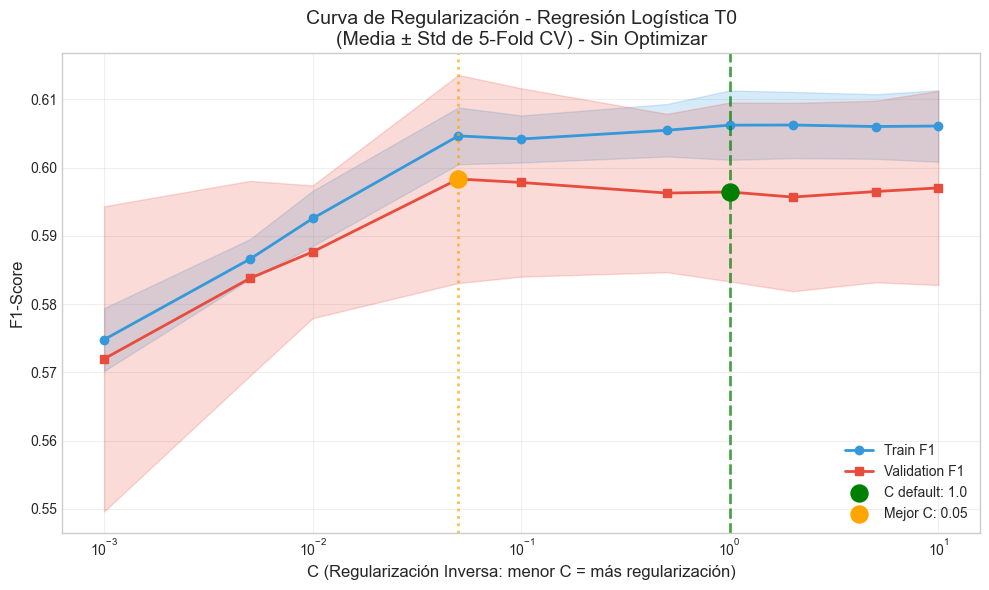


Resumen Curva de Regularización:
   C por defecto: 1.0
   Mejor C (curva): 0.05
   Train F1 en C=1.0: 0.6062
   Val F1 en C=1.0: 0.5964
   Gap en C=1.0: 0.0098
   Val F1 en mejor C: 0.5983
   Gap en mejor C: 0.0063

 Resumen Cross-Validation:

   Métrica        Train Mean    Train Std     Val Mean      Val Std
   ------------------------------------------------------------
   accuracy           0.7043       0.0039       0.6982       0.0138
   precision          0.5298       0.0047       0.5236       0.0181
   recall             0.7084       0.0059       0.6939       0.0240
   f1                 0.6062       0.0051       0.5964       0.0131
   roc_auc            0.7741       0.0018       0.7628       0.0067
Resultados guardados en: ../outputs/models/baseline_RL/cv_summary_RL.csv


In [27]:
# Entrenar y evaluar T0
results_T0 = entrena_RL(X_train_T0, y_train, fase='T0')


df_resumen_rl = resumen_cv(
    cv_results=results_T0['cv_results'],
    fase='T0',
    modelo='RegresionLogistica'
)
# Guardar tabla de comparación
df_resumen_rl.to_csv(f"{OUTPUT_DIR_REPORTES}cv_summary_RL.csv", index=False)

print(f"Resultados guardados en: {OUTPUT_DIR_REPORTES}cv_summary_RL.csv")  

### Optimización

  OPTIMIZACIÓN REGRESIÓN LOGÍSTICA CON OPTUNA - FASE T0

Variables: 32
Registros en train: 3539
Trials Optuna: 25
Métrica a optimizar: F1-score (clase Dropout)

Proceso de optimización

  MEJORES HIPERPARÁMETROS
  Mejor F1-score (CV): 0.5995
    C: 0.10797008358160833
    max_iter: 1758

Genera curva de aprendizaje


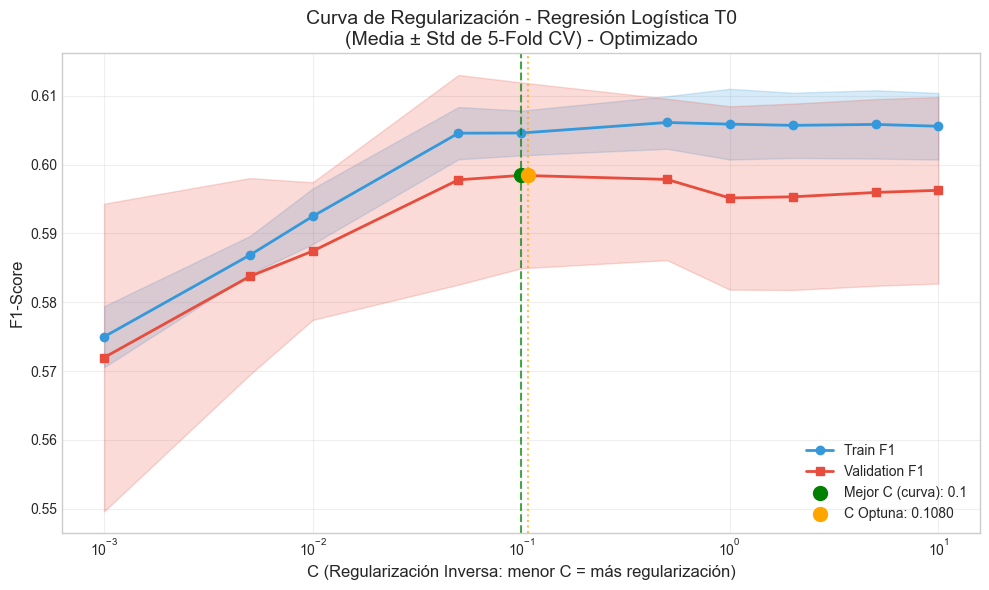


Resumen Curva de Regularización:
   Mejor C (curva): 0.1
   C Optuna: 0.1080
   Train F1 en mejor C: 0.6046
   Val F1 en mejor C: 0.5984
   Gap (Train - Val): 0.0062

  RESUMEN CROSS-VALIDATION (Optimizado)

   Métrica        Train Mean  Train Std     Val Mean    Val Std
   ------------------------------------------------------------
   accuracy           0.7032     0.0030       0.7002     0.0121
   precision          0.5284     0.0037       0.5256     0.0154
   recall             0.7076     0.0034       0.6983     0.0227
   f1                 0.6050     0.0033       0.5995     0.0125****
   roc_auc            0.7723     0.0017       0.7629     0.0062

Comparación F1-score:
  Baseline: 0.5964
  Optuna:   0.5995

Resultados guardados en: ../outputs/models/baseline_RL/cv_summary_RL.csv


In [28]:
results_T0_optuna = entrena_RL_con_optuna(X_train_T0, y_train, fase='T0', n_trials=25)

# Comparar baseline vs optimizado
print(f"\nComparación F1-score:")
print(f"  Baseline: {results_T0['cv_results']['test_f1'].mean():.4f}")
print(f"  Optuna:   {results_T0_optuna['best_f1_sore_cv']:.4f}")

df_resumen_rl_T0_opt = resumen_cv(
    cv_results=results_T0_optuna['cv_results'],
    fase='T0',
    modelo='RegresionLogistica_opt'
)

rl_path = "../outputs/models/baseline_RL/cv_summary_RL.csv"
df_rl = pd.read_csv(rl_path)
df_final = pd.concat([df_rl, df_resumen_rl_T0_opt], ignore_index=True)
csv_path = "cv_summary_RL.csv"

# Guardar tabla de comparación
df_final.to_csv(rl_path, index=False)
print(f"\nResultados guardados en: {OUTPUT_DIR_REPORTES}cv_summary_RL.csv")

### Comentarios FASE 0

1. En el resumen de la validación cruzada, se observa que la caída de las métricas en la validacion es en promedio de 0.0094, es pequeña y esperable, en consecuencia, buena capacidad de generalización.
2. Alta estabilidad, la desviación standard en baja en dentrenamiento y validación
3. En la validación, con solo la información al momento de la matrícula se obtiene un rendimiento moderado (recall 0.6948 y AUC 0.7625), lo que indica una capacidad razonable para identificar estudiantes en riesgo en una etapa temprana.
4. Estos resultados validan a la LR con un modelo baseline.
5. Respecto de la optimización priorizando la maximización del f1-score esta crece de forma marginal (+0.0036) y las métricas de interes aumentan tambien marginalmente, con un recall de 0.7019 (+0.08 respecto de la ejecución sin optimizar) y un roc-auc de 0.7620 (+0.0008), esto indica que el modelo baseline con parámetros por defecto ya estaba cerca del óptimo. Esto confirma que RL, siendo un modelo lineal simple, tiene capacidad limitada para capturar patrones complejos en los datos de deserción estudiantil, justificando la exploración de modelos más complejos como Gradient Boosting.


## 7. Modelado FASE T1 (FIN 1ER SEMESTRE)

In [29]:
# Preprocesamiento para T1
X_train_T1, X_test_T1, features_T1, prep_T1 = preprocesamiento_RL_con_transformaciones(
    X_train, X_test, y_train, fase='T1')

print(f"\n T1 - Dimensiones después del preprocesamiento:")
print(f"   Train: {X_train_T1.shape}")
print(f"   Test:  {X_test_T1.shape}")
print(f"   Features: {len(features_T1)}")


 T1 - Dimensiones después del preprocesamiento:
   Train: (3539, 43)
   Test:  (885, 43)
   Features: 43


### Parámetros por defecto

  ENTRENAMIENTO REGRESIÓN LOGÍSTICA - FASE T1

Variables: 43
 Cantidad de registros en dataset de entrenamiento: 3539

 Cross-Validation (5-fold):

 Resultados por fold:

  Fold 1:
    accuracy   | Train: 0.8608 | Val: 0.8150
    precision  | Train: 0.7685 | Val: 0.6964
    recall     | Train: 0.8108 | Val: 0.7544
    f1         | Train: 0.7891 | Val: 0.7242
    roc_auc    | Train: 0.9080 | Val: 0.8848

  Fold 2:
    accuracy   | Train: 0.8523 | Val: 0.8475
    precision  | Train: 0.7560 | Val: 0.7752
    recall     | Train: 0.7976 | Val: 0.7412
    f1         | Train: 0.7762 | Val: 0.7578
    roc_auc    | Train: 0.9082 | Val: 0.8871

  Fold 3:
    accuracy   | Train: 0.8509 | Val: 0.8333
    precision  | Train: 0.7596 | Val: 0.7121
    recall     | Train: 0.7846 | Val: 0.8062
    f1         | Train: 0.7719 | Val: 0.7562
    roc_auc    | Train: 0.9032 | Val: 0.9088

  Fold 4:
    accuracy   | Train: 0.8474 | Val: 0.8531
    precision  | Train: 0.7500 | Val: 0.7531
    recall     | Trai

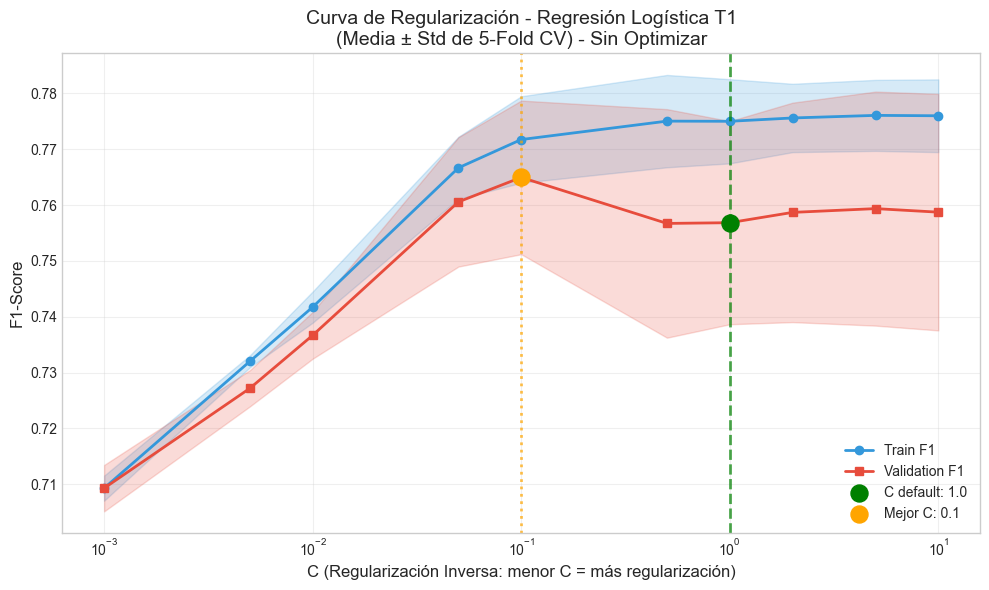


Resumen Curva de Regularización:
   C por defecto: 1.0
   Mejor C (curva): 0.1
   Train F1 en C=1.0: 0.7750
   Val F1 en C=1.0: 0.7568
   Gap en C=1.0: 0.0182
   Val F1 en mejor C: 0.7650
   Gap en mejor C: 0.0068

 Resumen Cross-Validation:

   Métrica        Train Mean    Train Std     Val Mean      Val Std
   ------------------------------------------------------------
   accuracy           0.8519       0.0048       0.8392       0.0138
   precision          0.7571       0.0066       0.7376       0.0289
   recall             0.7938       0.0096       0.7784       0.0266
   f1                 0.7750       0.0075       0.7568       0.0182
   roc_auc            0.9058       0.0021       0.8967       0.0098

Resultados guardados en: ../outputs/models/baseline_RL/cv_summary_RL.csv


In [30]:
# Entrenar y evaluar T1
results_T1 = entrena_RL(X_train_T1, y_train, fase='T1')

df_resumen_rl_T1 = resumen_cv(
    cv_results=results_T1['cv_results'],
    fase='T1',
    modelo='RegresionLogistica'
)

rl_path = "../outputs/models/baseline_RL/cv_summary_RL.csv"
df_rl = pd.read_csv(rl_path)
df_final = pd.concat([df_rl, df_resumen_rl_T1], ignore_index=True)
csv_path = "cv_summary_RL.csv"

# Guardar tabla de comparación
df_final.to_csv(rl_path, index=False)
print(f"\nResultados guardados en: {OUTPUT_DIR_REPORTES}cv_summary_RL.csv")

### Optimización

  OPTIMIZACIÓN REGRESIÓN LOGÍSTICA CON OPTUNA - FASE T1

Variables: 43
Registros en train: 3539
Trials Optuna: 25
Métrica a optimizar: F1-score (clase Dropout)

Proceso de optimización

  MEJORES HIPERPARÁMETROS
  Mejor F1-score (CV): 0.7648
    C: 0.10337036924312236
    max_iter: 672

Genera curva de aprendizaje


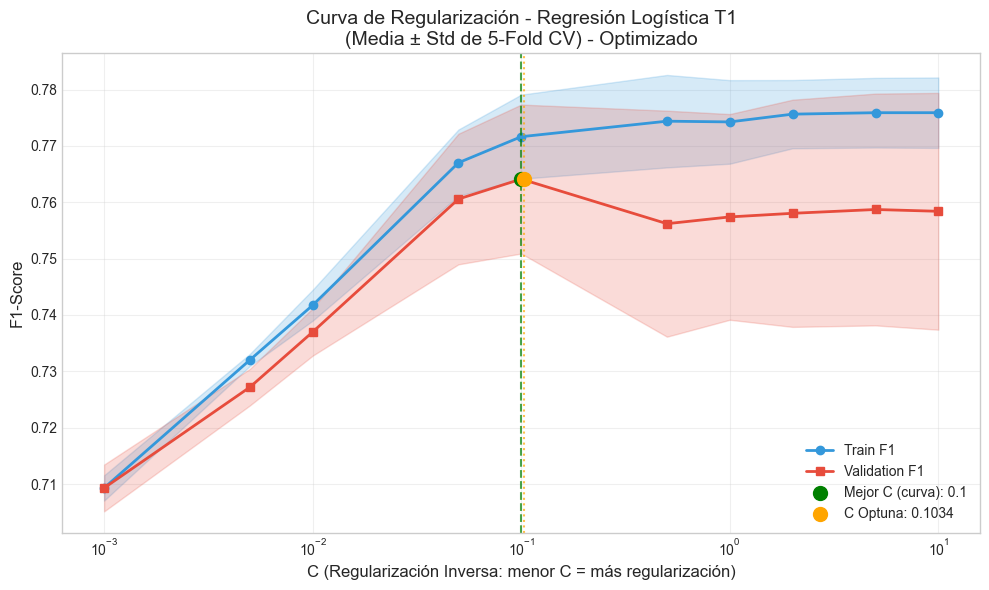


Resumen Curva de Regularización:
   Mejor C (curva): 0.1
   C Optuna: 0.1034
   Train F1 en mejor C: 0.7716
   Val F1 en mejor C: 0.7641
   Gap (Train - Val): 0.0075

  RESUMEN CROSS-VALIDATION (Optimizado)

   Métrica        Train Mean  Train Std     Val Mean    Val Std
   ------------------------------------------------------------
   accuracy           0.8495     0.0049       0.8440     0.0101
   precision          0.7520     0.0070       0.7431     0.0244
   recall             0.7933     0.0085       0.7890     0.0250
   f1                 0.7721     0.0075       0.7648     0.0128****
   roc_auc            0.9039     0.0021       0.8967     0.0094

Comparación F1-score:
  Baseline: 0.7568
  Optuna:   0.7648


In [31]:
results_T1_optuna = entrena_RL_con_optuna(X_train_T1, y_train, fase='T1', n_trials=25)

# Comparar baseline vs optimizado
print(f"\nComparación F1-score:")
print(f"  Baseline: {results_T1['cv_results']['test_f1'].mean():.4f}")
print(f"  Optuna:   {results_T1_optuna['best_f1_sore_cv']:.4f}")

df_resumen_rl_T1_opt = resumen_cv(
    cv_results=results_T1_optuna['cv_results'],
    fase='T1',
    modelo='RegresionLogistica_opt'
)

rl_path = "../outputs/models/baseline_RL/cv_summary_RL.csv"
df_rl = pd.read_csv(rl_path)
df_final = pd.concat([df_rl, df_resumen_rl_T1_opt], ignore_index=True)
csv_path = "cv_summary_RL.csv"

# Guardar tabla de comparación
df_final.to_csv(rl_path, index=False)

### Comentarios FASE 1

1. En el resumen de la validación cruzada, se observa que la caída de las métricas en la validacion es en promedio de 0.0148, la cual si bien aumenta levemente, es pequeña y esperable. Esto sugiere que continua con una buena capacidad de generalización.
2. Alta estabilidad, la desviación standard en baja en entrenamiento y validación, aunque ligeramente superior a T0, puede explicarse con el aumento de variables.
3. En la validación, con la información al momento de la matrícula y el primer semestre, se obtiene una **mejora relevante** con un rendimiento bueno ya que predice a los desertores sobre el 70% y con una mejor capacidad discriminativa (recall 0.7793 y AUC 0.8973) 
4. En esta fase se consolida a la RL como baseline sólido.
5. Respecto de la optimización priorizando la maximización del f1-score esta crece de forma marginal (+0.008) y las métricas de interes aumentan tambien marginalmente, con un recall de 0.7890 (+0.0106 respecto de la ejecución sin optimizar) y un roc-auc de 0.8967 (se mantuvo), esto indica que el modelo baseline con parámetros por defecto ya estaba cerca del óptimo al igual que la Fase 0. Esto es consistente con la naturaleza del modelo, que tiene pocos hiperparámetros con impacto significativo. El principal hallazgo es que la incorporación de variables académicas del primer semestre (Fase T0 a Fase T1) mejora el F1-score de 0.60 a 0.76 (+26.7%), siendo este el factor más determinante en el rendimiento del modelo, más que la optimización de hiperparámetros.

## 8. Modelado FASE T2 (FIN 2DO SEMESTRE)

In [32]:
# Preprocesamiento para T2
X_train_T2, X_test_T2, features_T2, prep_T2 = preprocesamiento_RL_con_transformaciones(
    X_train, X_test, y_train, fase='T2')

print(f"\n T2 - Dimensiones después del preprocesamiento:")
print(f"   Train: {X_train_T2.shape}")
print(f"   Test:  {X_test_T2.shape}")
print(f"   Features: {len(features_T2)}")


 T2 - Dimensiones después del preprocesamiento:
   Train: (3539, 49)
   Test:  (885, 49)
   Features: 49


### Parámetros por defecto

  ENTRENAMIENTO REGRESIÓN LOGÍSTICA - FASE T2

Variables: 49
 Cantidad de registros en dataset de entrenamiento: 3539

 Cross-Validation (5-fold):

 Resultados por fold:

  Fold 1:
    accuracy   | Train: 0.8795 | Val: 0.8460
    precision  | Train: 0.8002 | Val: 0.7352
    recall     | Train: 0.8328 | Val: 0.8158
    f1         | Train: 0.8162 | Val: 0.7734
    roc_auc    | Train: 0.9275 | Val: 0.9038

  Fold 2:
    accuracy   | Train: 0.8718 | Val: 0.8757
    precision  | Train: 0.7862 | Val: 0.8211
    recall     | Train: 0.8251 | Val: 0.7851
    f1         | Train: 0.8052 | Val: 0.8027
    roc_auc    | Train: 0.9264 | Val: 0.9082

  Fold 3:
    accuracy   | Train: 0.8746 | Val: 0.8743
    precision  | Train: 0.7994 | Val: 0.7760
    recall     | Train: 0.8143 | Val: 0.8546
    f1         | Train: 0.8068 | Val: 0.8134
    roc_auc    | Train: 0.9214 | Val: 0.9311

  Fold 4:
    accuracy   | Train: 0.8718 | Val: 0.8446
    precision  | Train: 0.7894 | Val: 0.7511
    recall     | Trai

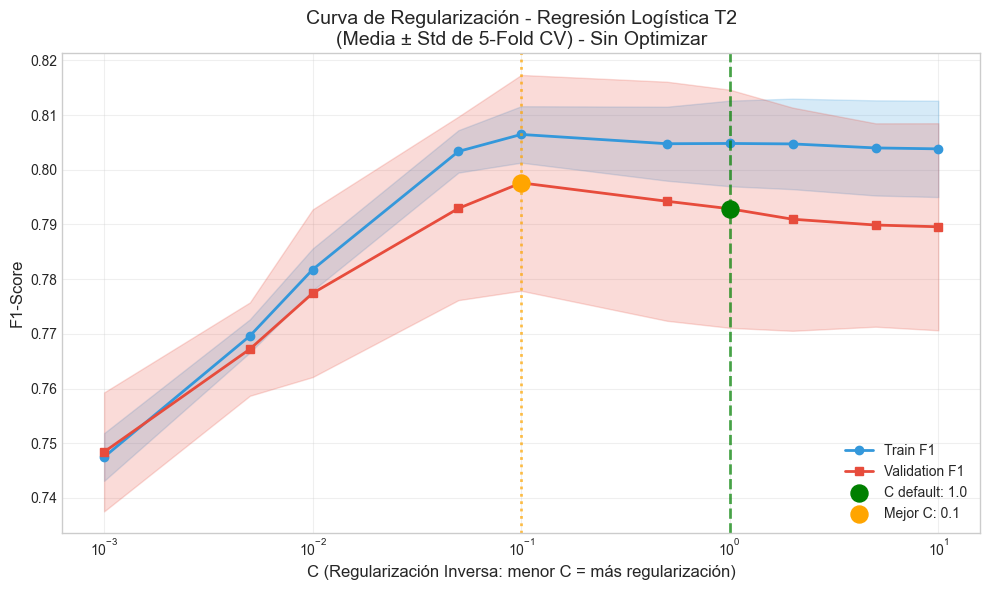


Resumen Curva de Regularización:
   C por defecto: 1.0
   Mejor C (curva): 0.1
   Train F1 en C=1.0: 0.8048
   Val F1 en C=1.0: 0.7929
   Gap en C=1.0: 0.0119
   Val F1 en mejor C: 0.7976
   Gap en mejor C: 0.0088

 Resumen Cross-Validation:

   Métrica        Train Mean    Train Std     Val Mean      Val Std
   ------------------------------------------------------------
   accuracy           0.8720       0.0056       0.8641       0.0154
   precision          0.7891       0.0109       0.7784       0.0327
   recall             0.8212       0.0070       0.8092       0.0292
   f1                 0.8048       0.0078       0.7929       0.0218
   roc_auc            0.9247       0.0026       0.9155       0.0112

Resultados guardados en: ../outputs/models/baseline_RL/cv_summary_RL.csv


In [33]:
# Entrenar y evaluar T2
results_T2 = entrena_RL(X_train_T2, y_train, fase='T2')


df_results_T2 = resumen_cv(
    cv_results=results_T2['cv_results'],
    fase='T2',
    modelo='RegresionLogistica'
)

rl_path = "../outputs/models/baseline_RL/cv_summary_RL.csv"
df_rl = pd.read_csv(rl_path)
df_final = pd.concat([df_rl, df_results_T2], ignore_index=True)
csv_path = "cv_summary_RL.csv"

# Guardar tabla de comparación
df_final.to_csv(rl_path, index=False)
print(f"\nResultados guardados en: {OUTPUT_DIR_REPORTES}cv_summary_RL.csv")

### Optimización

  OPTIMIZACIÓN REGRESIÓN LOGÍSTICA CON OPTUNA - FASE T2

Variables: 49
Registros en train: 3539
Trials Optuna: 25
Métrica a optimizar: F1-score (clase Dropout)

Proceso de optimización

  MEJORES HIPERPARÁMETROS
  Mejor F1-score (CV): 0.7988
    C: 0.10445811865137014
    max_iter: 525

Genera curva de aprendizaje


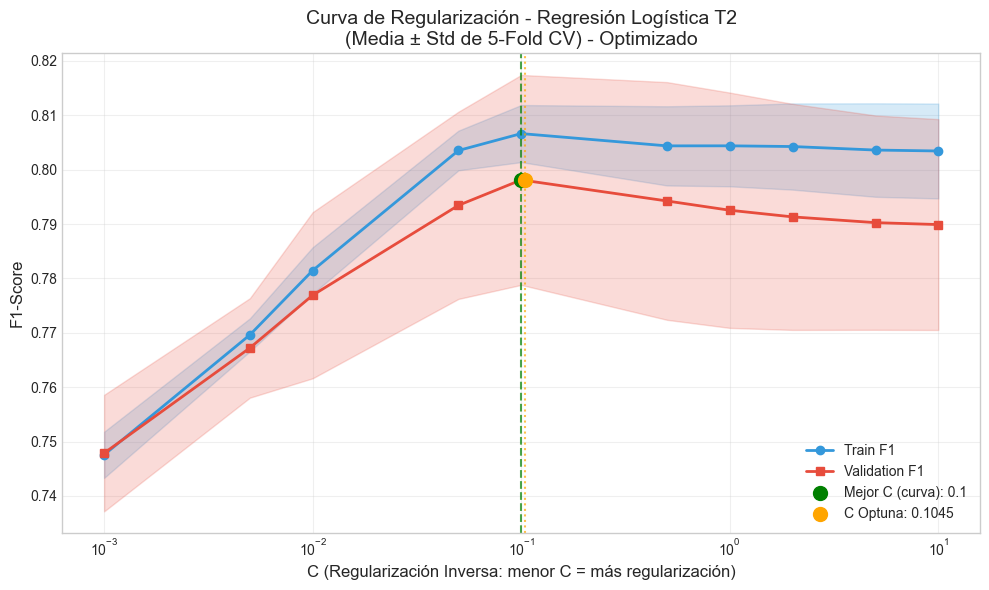


Resumen Curva de Regularización:
   Mejor C (curva): 0.1
   C Optuna: 0.1045
   Train F1 en mejor C: 0.8066
   Val F1 en mejor C: 0.7981
   Gap (Train - Val): 0.0085

  RESUMEN CROSS-VALIDATION (Optimizado)

   Métrica        Train Mean  Train Std     Val Mean    Val Std
   ------------------------------------------------------------
   accuracy           0.8729     0.0038       0.8675     0.0140
   precision          0.7891     0.0071       0.7816     0.0319
   recall             0.8250     0.0057       0.8179     0.0249
   f1                 0.8066     0.0054       0.7988     0.0190****
   roc_auc            0.9234     0.0026       0.9165     0.0113

Comparación F1-score:
  Baseline: 0.7929
  Optuna:   0.7988


In [34]:
results_T2_optuna = entrena_RL_con_optuna(X_train_T2, y_train, fase='T2', n_trials=25)

# Comparar baseline vs optimizado
print(f"\nComparación F1-score:")
print(f"  Baseline: {results_T2['cv_results']['test_f1'].mean():.4f}")
print(f"  Optuna:   {results_T2_optuna['best_f1_sore_cv']:.4f}")


df_resumen_rl_T2_opt = resumen_cv(
    cv_results=results_T2_optuna['cv_results'],
    fase='T2',
    modelo='RegresionLogistica_opt'
)

rl_path = "../outputs/models/baseline_RL/cv_summary_RL.csv"
df_rl = pd.read_csv(rl_path)
df_final = pd.concat([df_rl, df_resumen_rl_T2_opt], ignore_index=True)
csv_path = "cv_summary_RL.csv"

# Guardar tabla de comparación
df_final.to_csv(rl_path, index=False)

### Comentarios FASE 2

1. En el resumen de la validación cruzada, se observa que la caída de las métricas en la validacion es en promedio de 0.0094, es pequeña y esperable, en consecuencia, buena capacidad de generalización.
2. Alta estabilidad, la desviación standard permanece baja en entrenamiento y validación incluso con la incorporación de las variables de fase T2.
3. En la validación, con la información al momento de la matrícula, primer y segundo semestre, se obtiene una mejora adicional (aunque más moderada) con un recall 0.8136 y AUC 0.9163, lo que indica un alto poder discriminativo.
4. Estos resultados refuerzan el rol de la RL como baseline estable que sirve como punto de comparación con otro más complejos.
5. Respecto de la optimización priorizando la maximización del f1-score esta crece de forma marginal (+0.0061) y las métricas de interes aumentan tambien marginalmente, con un recall de 0.7990 (+0.079 respecto de la ejecución sin optimizar) y un roc-auc de 0.9165 (+0.001), esto indica que el modelo baseline con parámetros por defecto ya estaba cerca del óptimo al igual que la Fases anterioires. Esto confirma que el factor determinante es la incorporación de inforamación académica más no el ajuste de hiperparámetros.

## 9. Resumen Final Regresión lineal

In [35]:
# Mostrar resumen final
df_final = pd.read_csv(f"{OUTPUT_DIR_REPORTES}cv_summary_RL.csv")

print("================================================================================")
print("  RESUMEN Regresion Logistica - CROSS VALIDATION")
print("================================================================================")
print(df_final.to_string(index=False))

  RESUMEN Regresion Logistica - CROSS VALIDATION
                modelo fase  accuracy_val_mean  accuracy_val_std  precision_val_mean  precision_val_std  recall_val_mean  recall_val_std  f1_val_mean  f1_val_std  roc_auc_val_mean  roc_auc_val_std  accuracy_train_mean  accuracy_train_std  precision_train_mean  precision_train_std  recall_train_mean  recall_train_std  f1_train_mean  f1_train_std  roc_auc_train_mean  roc_auc_train_std
    RegresionLogistica   T0             0.6982            0.0138              0.5236             0.0181           0.6939          0.0240       0.5964      0.0131            0.7628           0.0067               0.7043              0.0039                0.5298               0.0047             0.7084            0.0059         0.6062        0.0051              0.7741             0.0018
RegresionLogistica_opt   T0             0.7002            0.0121              0.5256             0.0154           0.6983          0.0227       0.5995      0.0125            0.7629

## Conclusión

El incremento sostenido del ROC-AUC desde la fase T0 a la fase T2 evidencia de forma empírica que la incorporación de información académica mejora sustancialmente la capacidad discriminativa del modelo. Adiciaonalmente, el recall aumenta logrando una mayor efectividad de detección de estidiantes que desertan. La baja diferencia entre métricas de entrenamiento y validación confirma una adecuada generalización.